<a href="https://colab.research.google.com/github/study-groups/nlp-study-group/blob/master/projects/stanford-nlp/assignment2/assignment2_colab_notebooks/sinewave-tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis: Predicting future time-steps in a sine wave using a recurrent neural network

In this example we follow [Time-Series Analysis Using Recurrent Neural Networks in Tensorflow](https://medium.com/themlblog/time-series-analysis-using-recurrent-neural-networks-in-tensorflow-2a0478b00be7) by Tathagat Dasgupta. Here, we're solving a simple time-series problem in which we introduce a random batch of a sine wave to an RNN and predict the next value after the batch. This is a simple example so we're only predicting the values one time-step ahead. 

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

First we create a TimeSeriesData class to generate the sinusoidal data points and the batches for training.

In [0]:
class TimeSeriesData():
    def __init__(self,num_points,xmin,xmax):
        self.xmin=xmin
        self.xmax=xmax
        self.num_points=num_points
        self.resolution=(xmax-xmin)/num_points
        self.x_data=np.linspace(xmin,xmax,num_points)
        self.y_true=np.sin(self.x_data)
    
    # Returns sine values from series data inputed
    def ret_true(self,x_series): 
        return np.sin(x_series) 
    
    # Utility function which picks a random batch of points from data generated above
    def next_batch(self,batch_size,steps,return_batch_ts=False): 
        #Random starting point for batch
        random_start=np.random.rand(batch_size,1)
        
        #Put the random point on the time series
        ts_start=random_start*(self.xmax-self.xmin-(steps*self.resolution)) #Trick to convert any number into a point in the time series
        
        
        batch_ts=ts_start+np.arange(0.0,steps+1) * self.resolution #steps +1 because we are predicting just one tme step ahead
        
        y_batch=np.sin(batch_ts)
        
        #Formatting for RNN
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1,steps,1) , y_batch[:,1:].reshape(-1,steps,1), batch_ts
        else:
            return y_batch[:,:-1].reshape(-1,steps,1) , y_batch[:,1:].reshape(-1,steps,1) #Returning the sequence shifted over one time step

The ** __init__ ** function defines **x_data** and **y_true**.

# Plotting the Sinusoidal Wave

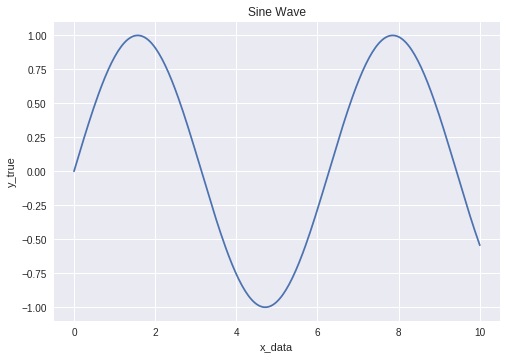

In [14]:
ts_data=TimeSeriesData(250,0,10)
plt.plot(ts_data.x_data,ts_data.y_true)
plt.xlabel('x_data')
plt.ylabel('y_true')
plt.title('Sine Wave')
plt.show()

# Generate random batch

(31,)


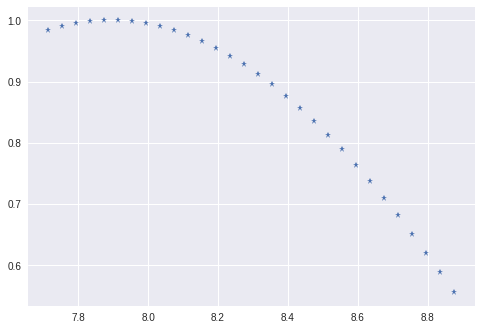

In [15]:
num_time_steps=30

y1,y2,ts= ts_data.next_batch(1,num_time_steps,True)

print(ts.flatten().shape) #The np.flatten() is explicitly used to reshape our vector so that we can plot our points.

plt.plot(ts.flatten()[1:],y1.flatten(),"*")
plt.show()

# Visualize our genererate batch on top of our sinewave

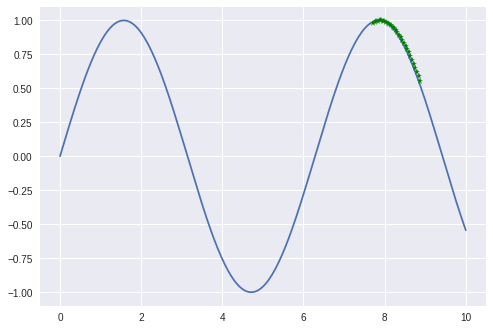

In [16]:
plt.plot(ts_data.x_data,ts_data.y_true)
plt.plot(ts.flatten()[1:],y1.flatten(),"g*")
plt.show()

# Declare placeholders and variables for convenience

In [0]:
num_inputs=1
num_neurons=100
num_outputs=1
learning_rate=0.001
num_iter=5000
batch_size=1

x=tf.placeholder(tf.float32,[None,num_time_steps,num_inputs])
y=tf.placeholder(tf.float32,[None,num_time_steps,num_outputs])

# Initiate RNN with GRU (Gated Reccurent Unit) cell

In [18]:
#ANY RNN CELL TYPE
cell=tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.GRUCell(num_units=num_neurons,activation=tf.nn.relu),output_size=num_outputs)

outputs,states=tf.nn.dynamic_rnn(cell,x,dtype=tf.float32)

ValueError: ignored

In [0]:
# Random training instance we'll use for training
train_inst=np.linspace(5,5+ts_data.resolution*(num_time_steps+1),num_time_steps+1)

#MSE
loss=tf.reduce_mean(tf.square(outputs-y))
optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate)

train=optimizer.minimize(loss)

init=tf.global_variables_initializer()


x_new=np.sin(np.array(train_inst[:-1].reshape(-1,num_time_steps,num_inputs)))

#If using GPU, specify the fraction oof memory to be consumed
#gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.75)

In [0]:
with tf.Session() as sess:
    sess.run(init)
    
    for iter in range(num_iter):
        x_batch , y_batch = ts_data.next_batch(batch_size,num_time_steps)
        
        sess.run(train,feed_dict={x:x_batch,y:y_batch})
        
        if iter %100==0:
        
            mse=loss.eval(feed_dict={x:x_batch,y:y_batch})
            print(iter, "\tMSE",mse)
            
        y_pred=sess.run(outputs,feed_dict={x:x_new})

In [0]:
plt.title("TESTING THE MODEL")

#TRAINING INSTANCE
plt.plot(train_inst[:-1],np.sin(train_inst[:-1]),"bo",markersize=15,alpha=0.5,label="TRAINING INST")

#TARGET TO PREDICT 
plt.plot(train_inst[1:],np.sin(train_inst[1:]),"ko",markersize=8,label="TARGET")

#MODEL PREDCTION
plt.plot(train_inst[1:],y_pred[0,:,0],"r.",markersize=7,label="PREDICTIONS")

plt.xlabel("TIME")
plt.legend()
plt.tight_layout()

plt.show()